In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
import imghdr
import shutil
import random
# import the libraries as shown below
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
# from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import pickle
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l1_l2



2023-08-02 10:53:54.620272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
# Define input directory
input_dir = './Dataset/'

# Define output directories
train_dir = './Train'
val_dir = './Validation'
test_dir = './Test'

# Create output directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

# Define the percentage of images to use for validation and test sets
val_pct = 0.2  # 20% of images will be used for validation set
test_pct = 0.1  # 10% of images will be used for test set

# Loop through each subdirectory and move images to train, validation, or test set
for subdir in os.listdir(input_dir):
    subdir_path = os.path.join(input_dir, subdir)
    if os.path.isdir(subdir_path):
        files = os.listdir(subdir_path)
        random.shuffle(files)  # shuffle files randomly
        num_files = len(files)
        val_size = int(num_files * val_pct)
        test_size = int(num_files * test_pct)
        for i, file in enumerate(files):
            src_path = os.path.join(subdir_path, file)
            if i < val_size:
                dst_dir = os.path.join(val_dir, subdir)
            elif i < val_size + test_size:
                dst_dir = os.path.join(test_dir, subdir)
            else:
                dst_dir = os.path.join(train_dir, subdir)
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)
            dst_path = os.path.join(dst_dir, file)
            shutil.copy(src_path, dst_path)

In [5]:

# Set up the directories
train_dir = './Train/'
valid_dir = './Validation/'
test_dir = './Test/'

# Set up the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
input_shape = (299, 299, 3)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

# Load the InceptionV3 model without the top layer
inception = InceptionV3(
    include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the layers in the base model except the last two inception blocks
for layer in inception.layers[:-14]:
    layer.trainable = False

# Add a custom top layer to the model
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the final model
model = Model(inputs=inception.input, outputs=predictions)

# Define a learning rate scheduler


def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001


# Compile the model with a custom learning rate and metrics
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoint and early stopping callbacks
checkpoint_path = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=4,
    mode='min',
    verbose=1
)

# Define the learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(learning_rate_scheduler)

# Define a callback to save the history to a file


class SaveHistoryCallback(keras.callbacks.Callback):
    def __init__(self, filename):
        self.filename = filename

    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        with open(self.filename, 'wb') as f:
            pickle.dump(self.history, f)


# Calculate the number of steps for validation
validation_steps = len(valid_generator.filenames) // valid_generator.batch_size

# Fit the model with the defined callbacks
history_file = 'model_history.pickle'
history_callback = SaveHistoryCallback(history_file)

history = model.fit(
    train_generator,
    steps_per_epoch=len(
        train_generator.filenames) // train_generator.batch_size,
    epochs=25,
    validation_data=valid_generator,
    validation_steps=len(
        valid_generator.filenames) // valid_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback,
               lr_scheduler_callback, history_callback]
)
# Save the entire model
model.save('experiment 1 before the algorithms applied.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 1903 images belonging to 10 classes.
Found 536 images belonging to 10 classes.
Found 267 images belonging to 10 classes.
Epoch 1/25
13/59 [=====>........................] - ETA: 1:19 - loss: 2.2604 - accuracy: 0.2048

2023-08-02 10:56:15.123128: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 10:56:17.609514: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 10:56:50.382235: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 10:56:51.120436: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc

59/59 [==============================] - 170s 3s/step - loss: 1.7335 - accuracy: 0.4137 - val_loss: 0.7187 - val_accuracy: 0.7480

Epoch 00001: val_loss improved from inf to 0.71872, saving model to model_checkpoint.h5
Epoch 2/25
59/59 [==============================] - 118s 2s/step - loss: 0.6571 - accuracy: 0.7791 - val_loss: 0.4454 - val_accuracy: 0.8652

Epoch 00002: val_loss improved from 0.71872 to 0.44536, saving model to model_checkpoint.h5
Epoch 3/25
59/59 [==============================] - 127s 2s/step - loss: 0.5049 - accuracy: 0.8427 - val_loss: 0.4577 - val_accuracy: 0.8574

Epoch 00003: val_loss did not improve from 0.44536
Epoch 4/25
59/59 [==============================] - 105s 2s/step - loss: 0.4388 - accuracy: 0.8570 - val_loss: 0.4729 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.44536
Epoch 5/25
59/59 [==============================] - 104s 2s/step - loss: 0.3121 - accuracy: 0.8999 - val_loss: 0.4125 - val_accuracy: 0.8711

Epoch 00005: val_lo

Epoch 00001: val_loss improved from inf to 0.82795, saving model to model_checkpoint.h5
Epoch 2/25
59/59 [==============================] - 238s 4s/step - loss: 0.4078 - accuracy: 0.8723 - val_loss: 0.9907 - val_accuracy: 0.8047

Epoch 00002: val_loss did not improve from 0.82795
Epoch 3/25
59/59 [==============================] - 234s 4s/step - loss: 0.3368 - accuracy: 0.8863 - val_loss: 0.4901 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.82795 to 0.49010, saving model to model_checkpoint.h5
Epoch 4/25
59/59 [==============================] - 283s 5s/step - loss: 0.2595 - accuracy: 0.9181 - val_loss: 0.7567 - val_accuracy: 0.8457

Epoch 00004: val_loss did not improve from 0.49010
Epoch 5/25
59/59 [==============================] - 241s 4s/step - loss: 0.2527 - accuracy: 0.9157 - val_loss: 0.6075 - val_accuracy: 0.8789

Epoch 00005: val_loss did not improve from 0.49010
Epoch 6/25
59/59 [==============================] - 239s 4s/step - loss: 0.1864 - accuracy: 0.9329 - val_loss: 0.7131 - val_accuracy: 0.8672

Epoch 00006: val_loss did not improve from 0.49010
Epoch 7/25
59/59 [==============================] - 235s 4s/step - loss: 0.1975 - accuracy: 0.9416 - val_loss: 0.5850 - val_accuracy: 0.8770

Epoch 00007: val_loss did not improve from 0.49010
Epoch 8/25
59/59 [==============================] - 244s 4s/step - loss: 0.1281 - accuracy: 0.9601 - val_loss: 0.5352 - val_accuracy: 0.8809

Epoch 00008: val_loss did not improve from 0.49010
Epoch 00008: early stopping
9/9 [==============================] - 27s 3s/step - loss: 0.4812 - accuracy: 0.8839
Test Loss: 0.48118025064468384
Test Accuracy: 0.8838951587677002


Found 267 images belonging to 10 classes.


/home/surafelamsalu21/anaconda3/envs/surafel/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



Classification Report:

                    precision    recall  f1-score   support

    Acer campestre       0.97      0.88      0.92        34
      Acer negundo       0.80      0.92      0.86        36
     Arbutus unedo       0.98      0.92      0.95        51
     Betula utilis       1.00      0.93      0.96        14
Buxus sempervirens       0.93      0.93      0.93        46
       Pinus nigra       0.90      0.82      0.86        11
        Salix alba       0.77      0.62      0.69        16
     Smilax aspera       0.90      0.82      0.86        22
  Viburnum lantana       0.52      0.81      0.63        16
   Viburnum opulus       0.85      0.81      0.83        21

          accuracy                           0.87       267
         macro avg       0.86      0.85      0.85       267
      weighted avg       0.89      0.87      0.88       267



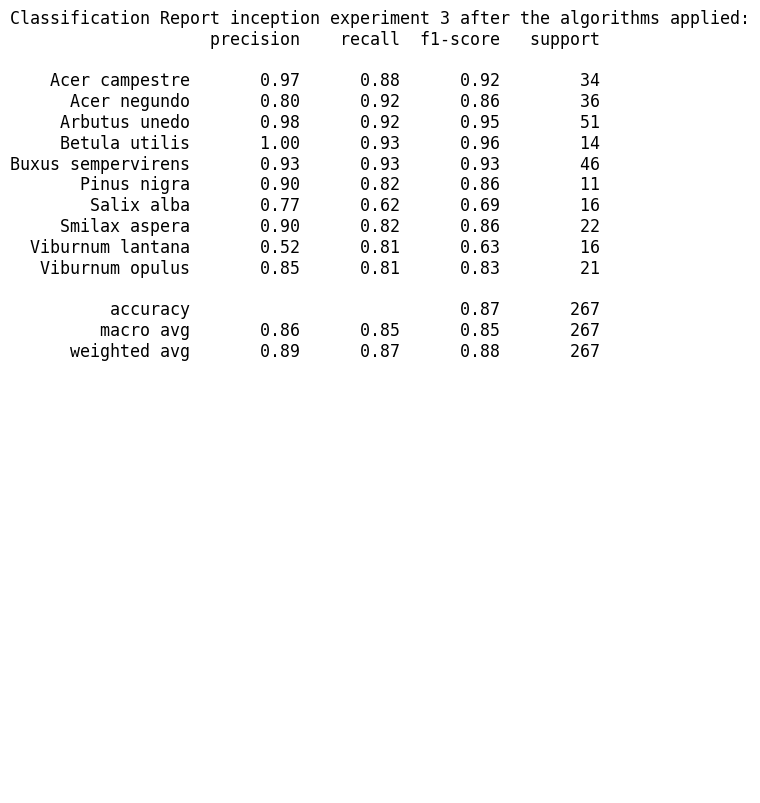

In [9]:
import os
from itertools import product
import sklearn


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Set up the directories
train_dir = './Train/'
valid_dir = './Validation/'
test_dir = './Test/'

# Define the image size and batch size for testing
img_size = 299
batch_size = 32

# Load the saved model
model = load_model(
    './experiment 1 before the algorithms applied.h5')

# Load and preprocess the test data using an image data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Get the predicted labels for the test data
y_pred = model.predict_generator(test_generator)

# Get the true labels for the test data
y_true = test_generator.classes

# Get the class names for the test data
class_names = list(test_generator.class_indices.keys())

# Print the classification report for the test data
print('\nClassification Report:\n')
y_pred_class = np.argmax(y_pred, axis=1)
classification_report_str = classification_report(
    y_true, y_pred_class, target_names=class_names)
print(classification_report_str)

# Save the classification report as an image
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.text(0, 0.9, 'Classification Report inception experiment 3 after the algorithms applied:\n' +
        classification_report_str, fontsize=12, family='monospace')
plt.savefig('Classification Report inception experiment 3 after the algorithms applied.png',
            bbox_inches='tight', pad_inches=0)

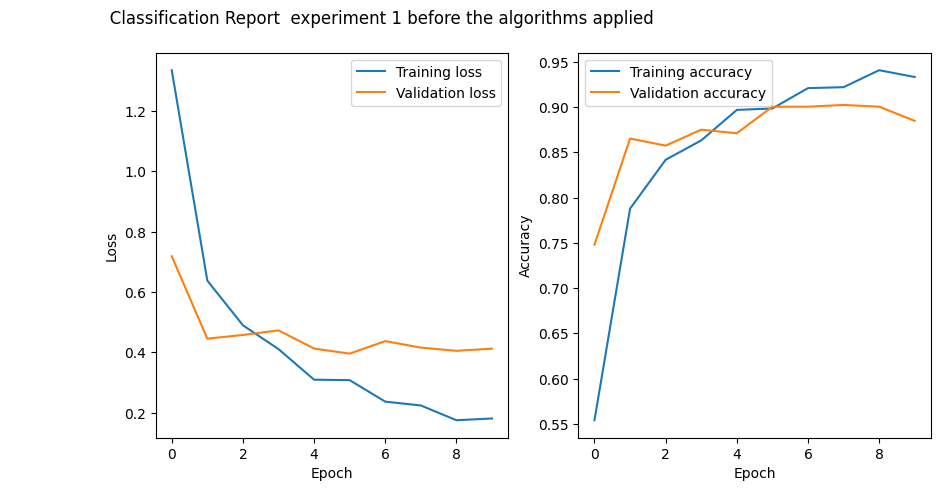

In [10]:
import matplotlib.pyplot as plt
import pickle

# Load the saved history object
with open('./model_history.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('                   Classification Report  experiment 1 before the algorithms applied\n')

# Plot the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.title('Training and Validation Accuracy before ')

plt.show()